# Ukiah Arrests Data cleanup and analysis
Source: [Ukiah arrests FOIA data](https://www.muckrock.com/foi/fort-bragg-3216/mendocino-county-law-enforcement-data-calls-for-service-arrests-complaints-fort-bragg-police-department-101427/)
- I converted to a messy excel file using https://pdftables.com/
- I then used `ukiah_pd.py` to clean up most of the messy excel
- Finally, we did manual data QA in a spreadsheet to remove any other errors.

### Subset charges to most serious offense per arrest
Each booking can have multiple charges per arrest. For analysis, it is more useful to focus on only the owrst charge per arrest. The next section subsets the charge to the one with the lowest sum code according to ____ (some organization)

In [138]:
import pandas as pd
import numpy as np

data = pd.read_csv('Ukiah_PD_Arrests_cleaned.csv')
codes = pd.read_csv('le_code.csv')
replace = data['Age'].isin(data['Race'].unique().tolist())
# data.loc[replace]
data.loc[replace,'Race']=data.loc[replace,'Age']
data.loc[replace,'Age']=np.NaN
data['Age']=pd.to_numeric(data['Age'])
def clean_charge(x):
    if x[-3:] in (' PC',' HS',' VC',' FG',' BP','UCC', 'CVC'):
        return x[:-3]
    return x
data['Charge'] = data['Charge'].apply(clean_charge).str.replace(' ','')
data['Felony/Misdemeanor'] = data['Felony/Misdemeanor'].str[:1]
codes['code_section_cleaned']=codes['Code\n Section'].str.replace(' ','')
codes['Sum_Code']=codes['Sum\n Code']
codes['Offense_Level']=codes['Off\nLevel']
data['Booking#']=data['Case Number']+'-'+data['Suspect Number'].astype(str)

In [139]:
data.head()

,Charge,Felony/Misdemeanor,Age,Race,Case Number,Suspect Number,Booking#
0,211,F,20.0,W,18-3171,1,18-3171-1
1,209(B),F,20.0,W,18-3171,1,18-3171-1
2,236,M,20.0,W,18-3171,1,18-3171-1
3,212.5(B),F,20.0,W,18-3171,1,18-3171-1
4,272(a)(1),F,20.0,W,18-3171,1,18-3171-1


In [140]:
data['Charge'].str[-3:].value_counts()

(A)    731
R/M    647
3.2    486
(F)    370
(1)    195
364    136
(B)    131
R/F    116
1.6     91
056     84
(M)     56
(a)     52
652     31
(D)     25
(4)     24
459     23
083     20
081     20
310     20
242     19
422     17
69      16
(2)     12
211     11
000     10
(b)     10
2.1      9
378      8
(H)      8
(e)      7
      ... 
155      2
(3)      2
32       2
350      2
488      2
(c)      2
9.5      2
ION      2
25       1
203      1
153      1
47       1
3PC      1
29A      1
84G      1
485      1
)WI      1
555      1
573      1
EDC      1
220      1
240      1
A)1      1
107      1
466      1
35       1
648      1
351      1
8.5      1
84e      1
Name: Charge, Length: 78, dtype: int64

In [144]:

# REFORMAT CODE TABLE TO MATCH DATA

# TAKE ONY THE LOWEST SUM CODE FOR EACH CODE
codes_clean = codes[['code_section_cleaned', 'Offense_Level','Sum_Code']].drop_duplicates().dropna()
codes_clean = codes_clean.loc[codes_clean.groupby(['code_section_cleaned','Offense_Level'])['Sum_Code'].idxmin()]

# SOME DATA CLEANUP
# data.loc[(data['Code']=='853.7'),'Felony/Misdemeanor']='M'
# data.loc[(data['Code']=='23152(A)'),'Felony/Misdemeanor']='M'
# data.loc[(data['Code']=='12022.1'),'Felony/Misdemeanor']='F'

# # JOIN DATA AND CODES
tst = data.merge(codes_clean, left_on=['Charge','Felony/Misdemeanor'], right_on=['code_section_cleaned','Offense_Level'], how='left')
# # IF CODE NOT PRESENT SET TO -1
tst.loc[tst['Sum_Code'].isnull(),'Sum_Code'] = -1

def sum_code_fix(x):
    if x['Felony/Misdemeanor']=='I':
        return 99
    if x['Felony/Misdemeanor']=='F':
        if x['Charge']=='209(B)':
            return 7
        if x['Charge']=='666':
            return 9
        if x['Charge'] in ['1203.2','1203.2(A)','12022.1']:
            return 28
    if x['Felony/Misdemeanor']=='M':
        if x['Charge']=='1203.2':
            return 67
        if x['Charge'] in ['23578', '23540']:
            return 51
        if x['Charge'] in ['20002','20002(A)']:
            return 52
        if x['Charge'] in ['484','484(A)/488','666/484(A)','666/484','6646/484']:
            return 31
        if x['Charge'].startswith('11357'):
            return 31
        if x['Charge']=='11550':
            return 36
        if x['Charge']=='23103':
            return 53
        if x['Charge']=='6081':
            return 60
        if x['Charge'].startswith('9.68.') or x['Charge'].startswith('09.68.') or (x['Charge']=='1170.12'):
            return 100
    return x['Sum_Code']


tst['Sum_Code_Fix'] = tst.apply(sum_code_fix, axis=1)
tst.loc[tst['Sum_Code_Fix']==-1,'Sum_Code_Fix']=99

# TAKE ONLY THE ROW WITH THE LOWEST SUM CODE
subset_tst = tst.loc[tst.groupby('Booking#')['Sum_Code_Fix'].idxmin()]

# MAKE SURE 1 OUTPUT PER BOOKING
assert subset_tst.shape[0]==tst['Booking#'].unique().shape[0]

# SAVE TO FILE
subset_tst.to_csv('upd_19_subset_worst_offense.csv',index=False)

In [145]:
tst.loc[tst['Sum_Code_Fix']==-1,'Charge'].value_counts()

Series([], Name: Charge, dtype: int64)

In [149]:
fb_demo

W    0
H    0
B    0
A    0
I    0
O    0
dtype: int64

/home/stedn/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


Text(0,0.5,u'Percentage By Race')

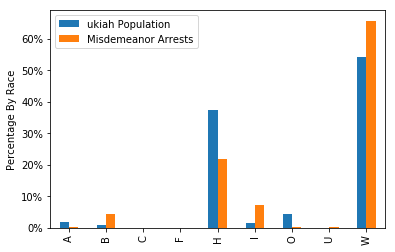

In [152]:
misdem = subset_tst.loc[subset_tst['Felony/Misdemeanor']=='M']
u_demo = pd.Series([8635./15946, 5943./15946, 128./15946, 289./15946, 257./15946, 694./15946],index=['W', 'H', 'B', 'A', 'I', 'O'])
toplot = pd.concat([u_demo,(misdem['Race'].value_counts()/misdem.shape[0])],axis=1)
toplot.columns = ['ukiah Population', 'Misdemeanor Arrests']
ax = toplot.plot.bar()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.ylabel('Percentage By Race')

Text(0,0.5,u'count')

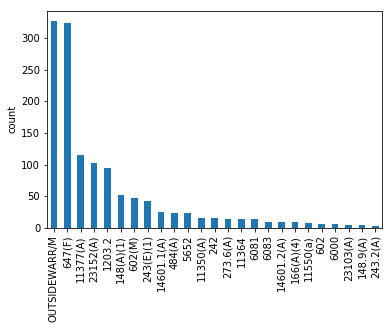

In [154]:
subset_tst.loc[subset_tst['Felony/Misdemeanor']=='M','Charge'].value_counts().head(25).plot.bar()
plt.ylabel('count')

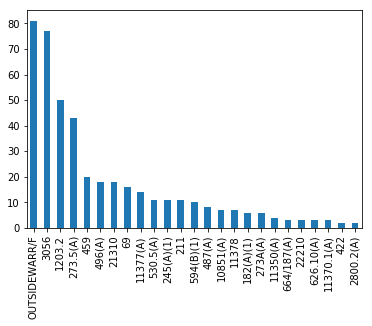

In [155]:
subset_tst.loc[subset_tst['Felony/Misdemeanor']=='F','Charge'].value_counts().head(25).plot.bar()